# import libraries and data

In [1]:
import os
import shutil
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions

In [2]:
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder_path):
    # Path
    path = os.path.join(parent_folder_path, folder_name)
    try:    
        # mode of the folder
        mode = 0o777
        # Create folder
        os.mkdir(path, mode)  
    except OSError as error: 
        print(error)

In [3]:
def calc_RMSE(df, epochs, type='train'):
    rmse = []
    for epoch in range(epochs):
        rms = mean_squared_error(df[str(epoch)], df.iloc[:,-1:], squared=False)
        rmse.append(rms)
    return rmse

In [4]:
def merge_folders(onlydir):
    # return if nothing to merge
    if not onlydir:
        return
    
    # merge folders
    current_folder = os.getcwd() 
    
    content_list = []
    for idx, dir in enumerate(onlydir):
        path = os.path.join(file_path, dir)
        content_list.append(os.listdir(path))
        
    # create merged folder name
    merge_folder = onlydir[0][:-7] + "_combined"
    merge_folder_path = os.path.join(current_folder, merge_folder) 
    make_new_folder(merge_folder, os.getcwd())
    
    # move files
    for idx, sub_dir in enumerate(onlydir):
        # loop through the contents of the list of folders
        for contents in content_list[idx]:

            # make the path of the content to move 
            path_to_content = file_path + sub_dir + "/" + contents  

            # make the path with the current folder
            dir_to_move = os.path.join(current_folder, path_to_content )

            # move the file
            shutil.copy(dir_to_move, merge_folder_path)
        
        # delete folder
        # os.rmdir(file_path + sub_dir)

# merge folders

In [5]:
# get list of folders in extracted
file_path = "extracted/"
current_folder = os.getcwd() 
onlydir = [f for f in listdir(file_path) if isdir(join(file_path, f))]
# print(onlydir)

In [6]:
# combine every 4 subfolders in a list
no_folders = 4
onlydir = [onlydir[x:x+no_folders] for x in range(0, len(onlydir), no_folders)]

In [7]:
for aggregation in onlydir:
    if len(aggregation) != no_folders:
        raise exception
    merge_folders(aggregation)

# key parameters for a single aggregation

In [8]:
# define where the latest dc_federated results are stored
latest_path = "06_08_2021_035945_combined/"

In [9]:
# define file names
train_name = "_yhat_train_worker_"
test_name = "_yhat_test_worker_"
worker_A = 'A.csv'
worker_B = 'B.csv'
worker_C = 'C.csv'

In [10]:
# get the number of aggregation rounds
onlyfiles = [f for f in listdir(latest_path) if isfile(join(latest_path, f))]
no_aggre = max([int(f.partition('_')[0]) for f in onlyfiles]) - 1
max_aggre = 5  # this is an important hyperparameter

# individual train results

In [11]:
# define how which epoch to take results from for graphing purposes
no_epochs = 10

Combined train RMSE: 45.37
Worker A final train RMSE: 45.55
Worker B final train RMSE: 45.42
Worker C final train RMSE: 45.14


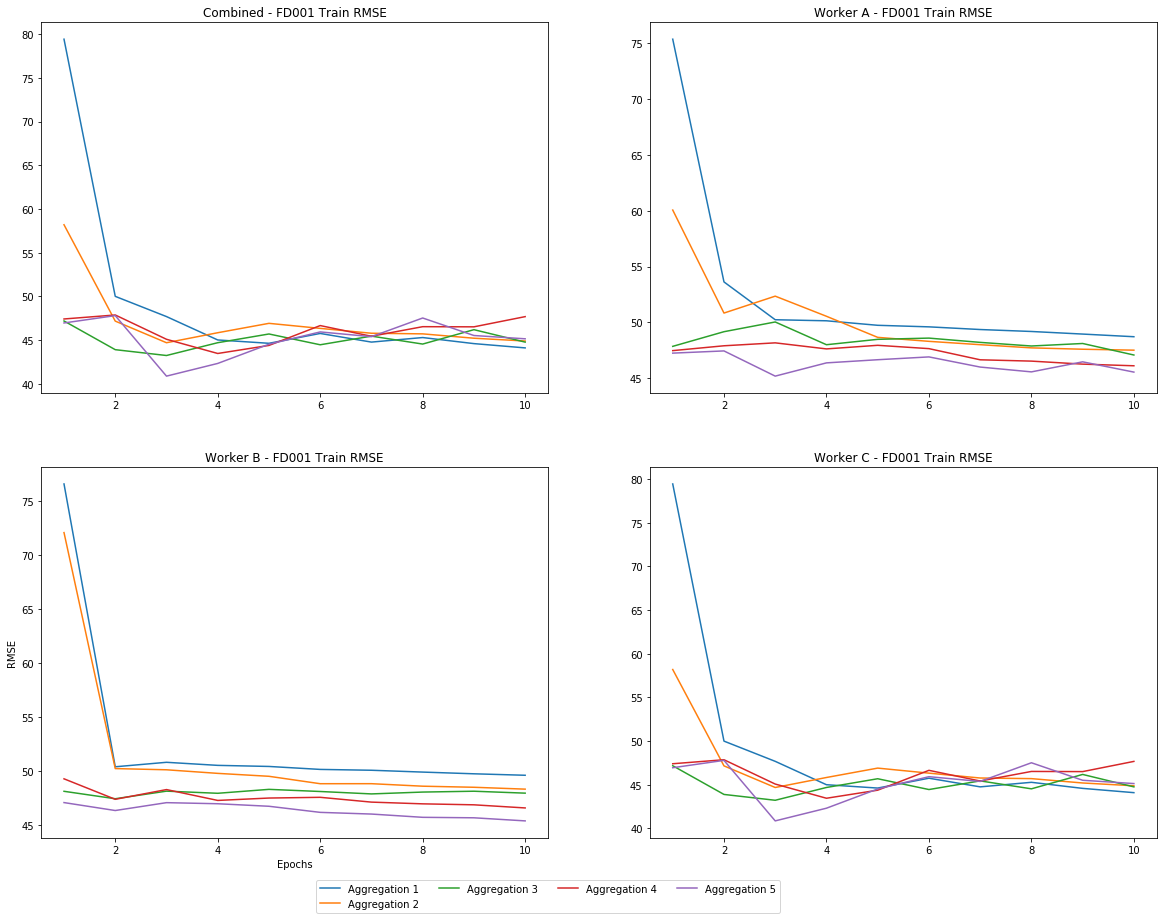

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))  # width x height)
rmse_A, rmse_B, rmse_C, rmse_total = 0, 0, 0, 0
for aggre in range(min(no_aggre, max_aggre)):
    aggre += 1
    df_A = pd.read_csv(latest_path + str(aggre) + train_name + worker_A)
    rmse_A = calc_RMSE(df_A, no_epochs)
    axes[0, 1].plot(range(1, len(rmse_A)+1), rmse_A, label="Aggregation "+str(aggre))
    
    df_B = pd.read_csv(latest_path + str(aggre) + train_name + worker_B)
    rmse_B = calc_RMSE(df_B, no_epochs)
    axes[1, 0].plot(range(1, len(rmse_B)+1), rmse_B, label="Aggregation "+str(aggre))
    
    df_C = pd.read_csv(latest_path + str(aggre) + train_name + worker_C)
    rmse_C = calc_RMSE(df_C, no_epochs)
    axes[1, 1].plot(range(1, len(rmse_C)+1), rmse_C, label="Aggregation "+str(aggre))
    
    df_total = df_A.append(df_B).append(df_C)
    rmse_total = calc_RMSE(df_total, no_epochs)
    axes[0, 0].plot(range(1, len(rmse_C)+1), rmse_C, label="Aggregation "+str(aggre))
  
print('Combined train RMSE: '+ '{0:.2f}'.format(rmse_total[-1]))  
print('Worker A final train RMSE: '+ '{0:.2f}'.format(rmse_A[-1]))  
print('Worker B final train RMSE: '+ '{0:.2f}'.format(rmse_B[-1]))  
print('Worker C final train RMSE: '+ '{0:.2f}'.format(rmse_C[-1]))  

axes[0, 0].title.set_text('Combined - FD001 Train RMSE') 
axes[0, 1].title.set_text('Worker A - FD001 Train RMSE') 
axes[1, 0].title.set_text('Worker B - FD001 Train RMSE') 
axes[1, 1].title.set_text('Worker C - FD001 Train RMSE') 

axes[1, 0].legend(loc='upper center', bbox_to_anchor=(1, -0.1), ncol=4)
_ = axes[1, 0].set_xlabel("Epochs")
_ = axes[1, 0].set_ylabel("RMSE")

# individual test results

Worker A final test RMSE: 30.89
Worker B final test RMSE: 34.64
Worker C final test RMSE: 34.49


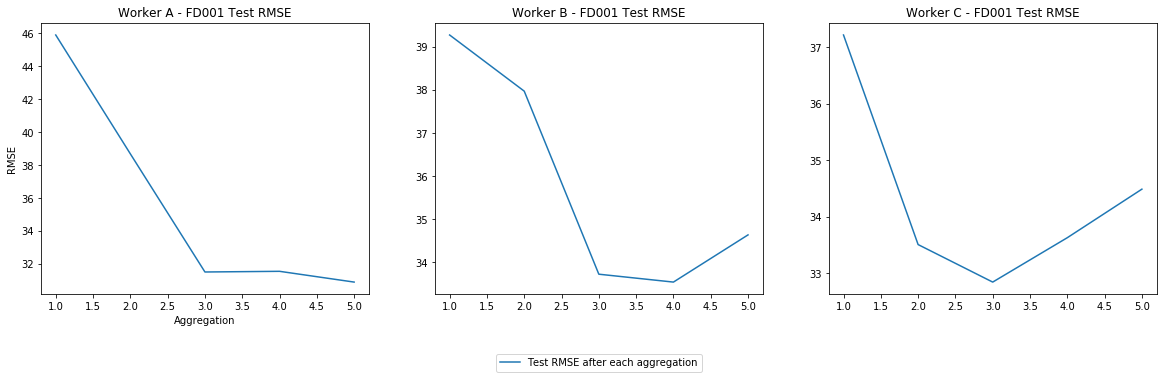

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # width x height)
rmse_A, rmse_B, rmse_C = 0, 0, 0

for i, worker in enumerate(['A.csv', 'B.csv', 'C.csv']):
    rmse_list = []
    for aggre in range(min(no_aggre, max_aggre)):
        df = pd.read_csv(latest_path + str(aggre+1) + test_name + worker)
        rmse = calc_RMSE(df, 1)
        rmse_list.append(rmse)
    axes[i].plot(range(1, len(rmse_list)+1), rmse_list, label="Test RMSE after each aggregation")
    print('Worker ' + chr(65+i) + ' final test RMSE: '+ '{0:.2f}'.format(rmse_list[-1][0]))

for i in range(3):
    axes[i].title.set_text('Worker ' + chr(65+i) + ' - FD001 Test RMSE')   

axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
_ = axes[0].set_xlabel("Aggregation")
_ = axes[0].set_ylabel("RMSE")

# list of all federated results

In [14]:
# get list of folders extracted
onlydir = [f for f in listdir(os.getcwd()) if isdir(join(os.getcwd(), f)) and "combined" in f]
# print(onlydir)

In [15]:
headers = ['id', 'train rmse A', 'train rmse B', 'train rmse C', 
           'test rmse A', 'test rmse B', 'test rmse C', 
           '# test rows A', '# test rows B', '# test rows C','combined test rmse']

In [16]:
content = []
for dir in onlydir:
    temp = [dir]
    latest_path = dir + "/"
    
    # calculate train rmse
    df_A_train = pd.read_csv(latest_path + str(max_aggre) + train_name + worker_A)
    no_epochs = len(df.columns.values) - 2
    temp.append(calc_RMSE(df_A_train, no_epochs)[-1])
    
    df_B_train = pd.read_csv(latest_path + str(max_aggre) + train_name + worker_B)
    temp.append(calc_RMSE(df_B_train, no_epochs)[-1])
    
    df_C_train = pd.read_csv(latest_path + str(max_aggre) + train_name + worker_C)
    temp.append(calc_RMSE(df_C_train, no_epochs)[-1])
     
    # calculate test rmse
    df_A_test = pd.read_csv(latest_path + str(max_aggre) + test_name + worker_A)
    temp.append(calc_RMSE(df_A_test, 1)[-1])
    
    df_B_test = pd.read_csv(latest_path + str(max_aggre) + test_name + worker_B)
    temp.append(calc_RMSE(df_B_test, 1)[-1])
    
    df_C_test = pd.read_csv(latest_path + str(max_aggre) + test_name + worker_C)
    temp.append(calc_RMSE(df_C_test, 1)[-1])   
    
    # add number of rows
    temp.append(len(df_A_test)) 
    temp.append(len(df_B_test)) 
    temp.append(len(df_C_test)) 
    
    # calculate combined rmse
    master = df_A_test.append(df_B_test).append(df_C_test)
    temp.append(calc_RMSE(master, 1)[-1])
        
    content.append(temp)

In [17]:
df_result = pd.DataFrame(content).round(2)
df_result.columns = headers
df_result.sort_values(['combined test rmse'], ascending=[True], inplace=True)
df_result.reset_index(inplace=True, drop=True)
# df_result.to_excel("dc_federated_result.xlsx")

In [18]:
# get hyperparameters of top 20 results
print('Federated NN results at the ' + str(max_aggre) + 'th aggregation:')
df_result.head(20)

Federated NN results at the 5th aggregation:


,id,train rmse A,train rmse B,train rmse C,test rmse A,test rmse B,test rmse C,# test rows A,# test rows B,# test rows C,combined test rmse
0,06_08_2021_154225_combined,23.90,17.00,18.25,17.80,48.49,18.13,2,8,594,18.85
1,06_08_2021_154356_combined,16.00,17.36,21.08,23.95,22.13,18.54,196,213,195,21.67
2,06_08_2021_154130_combined,19.82,19.66,20.45,30.13,24.67,23.09,196,213,195,26.10
3,06_08_2021_154036_combined,25.35,19.85,18.11,41.07,43.43,26.35,2,8,594,26.71
4,06_08_2021_152950_combined,26.15,24.04,27.98,27.16,32.37,30.61,196,213,195,30.19
5,06_08_2021_153345_combined,46.72,32.38,23.83,17.64,28.38,31.78,2,8,594,31.70
6,06_08_2021_121342_combined,39.85,34.15,47.60,34.49,27.27,32.97,2,8,594,32.91
7,06_08_2021_035945_combined,47.25,47.11,46.95,30.89,34.64,34.49,196,213,195,33.42
8,06_08_2021_025755_combined,47.75,46.48,47.55,34.99,35.61,31.25,196,213,195,34.06
9,06_08_2021_031902_combined,47.01,47.39,44.67,34.07,34.21,34.59,196,213,195,34.29


In [19]:
onlydir = df_result['id'].tolist()
headers = ['id', 'batch_size', 'learn_rate', 'epochs', 'iter_rounds', 'layer_1', 'layer_2', 'layer_3', 'dropout', 'activation']

In [20]:
content = []
for dir in onlydir:
    temp = [dir]
    latest_path = dir + "/"
    
    # append hyperparameters. All 3 parties have the same hyperparameters
    df_A = pd.read_csv(latest_path + '0_worker_A_hyperparamters.csv')
    row = df_A.loc[0].tolist()
    temp = [*temp, *row[1:]]          
    content.append(temp)

In [21]:
df_param = pd.DataFrame(content).round(2)
df_param.columns = headers

In [22]:
# edit layer 1, layer 2 and layer 3
layer_list = ['layer_1', 'layer_2', 'layer_3']
for layer in layer_list:
    df_param[layer] = [f.partition('=')[2].partition('=')[2].partition(',')[0] for f in df_param[layer]]

In [23]:
df_param.reset_index(inplace=True, drop=True)
df_param.head(20)

,id,batch_size,learn_rate,epochs,iter_rounds,layer_1,layer_2,layer_3,dropout,activation
0,06_08_2021_154225_combined,24,0.03,10,12,64,128,256,"Dropout(p=0.0, inplace=False)",sigmoid
1,06_08_2021_154356_combined,24,0.03,10,12,64,128,256,"Dropout(p=0.0, inplace=False)",sigmoid
2,06_08_2021_154130_combined,14,0.02,10,6,64,128,256,"Dropout(p=0.0, inplace=False)",relu
3,06_08_2021_154036_combined,14,0.02,10,6,64,128,256,"Dropout(p=0.0, inplace=False)",relu
4,06_08_2021_152950_combined,30,0.07,10,12,64,128,256,"Dropout(p=0.0, inplace=False)",relu
5,06_08_2021_153345_combined,12,0.09,10,5,256,512,1024,"Dropout(p=0.0, inplace=False)",relu
6,06_08_2021_121342_combined,45,0.06,10,8,64,128,256,"Dropout(p=0.0, inplace=False)",relu
7,06_08_2021_035945_combined,10,0.01,10,11,32,64,128,"Dropout(p=0.0, inplace=False)",relu
8,06_08_2021_025755_combined,30,0.03,10,14,16,32,64,"Dropout(p=0.0, inplace=False)",relu
9,06_08_2021_031902_combined,50,0.01,10,13,16,32,64,"Dropout(p=0.0, inplace=False)",relu


In [24]:
df_master=df_result.merge(df_param, on='id', how='left')
df_master.to_excel("dc_federated_master_result.xlsx")

# Only keep folders of top 100 results

In [25]:
list_to_be_deleted=df_master['id'].tolist()[100:]

In [26]:
for contents in list_to_be_deleted:
    dir_to_move = os.path.join(current_folder, contents)
    dest = os.path.join(current_folder, 'to_be_deleted')
    shutil.move(dir_to_move, dest)

Error: Destination path 'C:\Users\chanzl_thinkpad\Desktop\FATE-Ubuntu\dc_extracted\to_be_deleted\06_08_2021_153120_combined' already exists